<center><img src="https://keras.io/img/logo-small.png" alt="Keras logo" width="100"><br/>
This starter notebook is provided by the Keras team.</center>

## Keras NLP starter guide here: https://keras.io/guides/keras_nlp/getting_started/

In this competition, the challenge is to build a machine learning model that predicts which Tweets are about real disasters and which one’s aren’t.
A dataset of 10,000 tweets that were hand classified is available. 

__This starter notebook uses the [DistilBERT](https://arxiv.org/abs/1910.01108) pretrained model from KerasNLP.__


**BERT** stands for **Bidirectional Encoder Representations from Transformers**. BERT and other Transformer encoder architectures have been wildly successful on a variety of tasks in NLP (natural language processing). They compute vector-space representations of natural language that are suitable for use in deep learning models.

The BERT family of models uses the **Transformer encoder architecture** to process each token of input text in the full context of all tokens before and after, hence the name: Bidirectional Encoder Representations from Transformers.

BERT models are usually pre-trained on a large corpus of text, then fine-tuned for specific tasks.

**DistilBERT model** is a distilled form of the **BERT** model. The size of a BERT model was reduced by 40% via knowledge distillation during the pre-training phase while retaining 97% of its language understanding abilities and being 60% faster.



![BERT Architecture](https://www.cse.chalmers.se/~richajo/nlp2019/l5/bert_class.png)



In this notebook, you will:

- Load the Disaster Tweets
- Explore the dataset
- Preprocess the data
- Load a DistilBERT model from Keras NLP
- Train your own model, fine-tuning BERT
- Generate the submission file


In [41]:
!pip install keras-core --upgrade
!pip install -q keras-nlp --upgrade

# This sample uses Keras Core, the multi-backend version of Keras.
# The selected backend is TensorFlow (other supported backends are 'jax' and 'torch')
import os
os.environ['KERAS_BACKEND'] = 'tensorflow'

In [42]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
import keras_core as keras
import keras_nlp
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

print("TensorFlow version:", tf.__version__)
print("KerasNLP version:", keras_nlp.__version__)

TensorFlow version: 2.12.0
KerasNLP version: 0.6.2


# Load the Disaster Tweets
Let's have a look at the train and test dataset.

They contain:
- id
- keyword: A keyword from that tweet (although this may be blank!)
- location: The location the tweet was sent from (may also be blank)
- text: The text of a tweet
- target: 1 if the tweet is a real disaster or 0 if not

In [43]:
df_train = pd.read_csv("/kaggle/input/new-dataset/train.csv")
df_test = pd.read_csv("/kaggle/input/new-dataset/test.csv")

print('Training Set Shape = {}'.format(df_train.shape))
print('Training Set Memory Usage = {:.2f} MB'.format(df_train.memory_usage().sum() / 1024**2))
print('Test Set Shape = {}'.format(df_test.shape))
print('Test Set Memory Usage = {:.2f} MB'.format(df_test.memory_usage().sum() / 1024**2))

df_train

Training Set Shape = (50, 6)
Training Set Memory Usage = 0.00 MB
Test Set Shape = (1100, 5)
Test Set Memory Usage = 0.04 MB


,id,sentence1,sentence2,sentence3,sentence4,label
0,TRAIN_000,"직원들 마음에 들지 않는다는 것은 알겠지만, 가지 말아야 할까? 인터넷에서 싸게 살...",직원들 진짜 싸가지 없어요 ㅋㅋㅋㅋ 가지 마숑 인터넷이 더 싼거 알면서도 이것저것...,직원들 정말 싸가지 없네요 ㅋㅋㅋㅋ 인터넷에서 더 싸게 구입할 수 있다는 걸 알면서...,직원들의 태도가 정말 별로였어요 ㅋㅋㅋㅋ 가볼만한 가게라는 소문을 듣고 인터넷으로 ...,2
1,TRAIN_001,분위기 최고! 2층 창문이 넓어서 공기가 통하는 느낌이에요. 조명도 멋지고 음료와 ...,분위기가 너무 좋아요! 2층 창문이 넓어서 쾌적한 느낌이에요. 조명도 아름답고 음료...,분위기가 짱!! 2층 창문이 커서 탁 트여있는 느낌이에요 ㅎㅎ 조명도 예쁘고 음료랑...,분위기가 너무 좋아요! 2층 창문이 크고 넓어서 탁 트여있는 느낌이에요. 조명도 예...,3
2,TRAIN_002,"일단, 장사가 잘 되길 바라는 마음에서 별 다섯 개 드립니다. 간도 딱 맞았고, 저...",일단 장사가 잘되길 바라는 마음에서 별5개 드립니다 간도 맞았고 매운걸 좋아하는 입...,일단 저는 장사가 잘되기를 바라는 마음에서 별 다섯 개를 주고 싶어요. 맛도 딱 맞...,"먼저, 칭찬과 응원의 의미로 별 다섯 개를 주고 싶습니다. 간도 딱 맞고, 저는 매...",2
3,TRAIN_003,"1편의 독특함 때문에 살짝 뒤로 밀린 느낌이 있지만, 여전히 재미있어요. 게임 시스...","1편의 신선함에 비해 약간 빛이 바래 보이지만, 여전히 재미있게 즐길 수 있어요. ...","1편의 독특함 때문에 약간의 비교가 불가피하지만, 이 게임은 여전히 흥미로워요. 시...",1편이 워낙 참신했던 탓에 좀 묻힌 감이 있긴 하지만 재미는 여전합니다. 시스템도 ...,4
4,TRAIN_004,"빵점 주고 싶은걸 간신히 참았다...이런건 사상 유래가 없는,조지 루카스 영감의 스...",빵점을 주고 싶지만 참아냈습니다... 이 영화는 사상 유래가 없는 것 같아요. 조지...,빵점 주고 싶을 정도로 엄청 실망했어요... 이 영화는 별들의 전쟁처럼 역사적인 작...,"빵점을 주고 싶었는데 참았어요... 이런 영화는 전례가 없는데, 조지 루카스의 스타...",1
5,TRAIN_005,"치킨 반마리 주문 가능. 골뱅이소면과 함께 추천. 치킨은 평범, 사이드메뉴와 함께하...",둘이서 치킨 반마리 주문이 가능해서 골뱅이소면무침랑 같이 시킬 수 있었네요! 치킨맛...,"두 사람이서 반마리의 치킨을 주문할 수 있어서, 골뱅이소면무침을 함께 주문했습니다....",두 사람이서 치킨 반마리 주문이 가능해서 골뱅이소면무침과 함께 먹을 수 있었습니다....,2
6,TRAIN_006,진짜 일하시는 사람들 너무 시끄러워요 자기들 개인사얘기하는데 목소리도 크고 밥이 ...,진짜 시끄러운데... 이런거 시끄러워서 돈 아까워.,진짜 이 직장은 너무 시끄럽네요. 직원들끼리만 얘기하는게 아니라 목소리도 크고 밥먹...,"진짜 일하는 분들이 너무 시끄러웠어요. 개인적인 이야기를 할 때도 목소리가 크고, ...",1
7,TRAIN_007,"우와 정말 멋진 스터디 카페입니다. 다른 지점은 가보지 않았지만, 노트북을 많이 사...","와우, 정말 좋아요! 이 스터디 카페는 정말 최고예요. 다른 지점은 가보지 않았지만...","와우, 정말 좋은 공부 카페예요. 다른 지점은 가본 적은 없지만, 노트북을 많이 사...",우와 완전좋아요 스터디카페 신세계 ... 다른지점은 안가봤지만 노트북많이쓰는데 노트...,4
8,TRAIN_008,가시려는 분들은 이전 리뷰를 잘 읽어보고 가는 것을 추천합니다. 급하게 여기에서 상...,가시고자 하시는 분들은 앞서 쓴 후기 잘 읽어보고 가세요. 급해서 여기서 상견례했는...,이 식당을 방문하실 분들께는 앞선 리뷰들을 잘 읽어보시고 결정하시는 것을 추천드립니...,요즘은 리뷰를 믿기 힘들죠. 하지만 제 경험을 공유하고자 해요. 급하게 가서 상견례...,2
9,TRAIN_009,라운즈 앱에서 안경 구매 후 도수렌즈 구매했어요. 제가 눈이 나쁘고 렌즈 결정하기가...,라운즈 앱을 통해 안경과 도수 렌즈를 구입했습니다. 저의 시력이 좋지 않아서 렌즈 ...,라운즈 앱을 통해 안경과 도수렌즈를 구매하였습니다. 제 시력이 좋지 않아 렌즈 결정...,라운즈 앱으로 안경 구매 및 도수렌즈 선택. 눈 상태 때문에 까다롭지만 직원 친절함...,1


In [44]:
train_2=df_train.iloc[:,1:-1]
train_2

,sentence1,sentence2,sentence3,sentence4
0,"직원들 마음에 들지 않는다는 것은 알겠지만, 가지 말아야 할까? 인터넷에서 싸게 살...",직원들 진짜 싸가지 없어요 ㅋㅋㅋㅋ 가지 마숑 인터넷이 더 싼거 알면서도 이것저것...,직원들 정말 싸가지 없네요 ㅋㅋㅋㅋ 인터넷에서 더 싸게 구입할 수 있다는 걸 알면서...,직원들의 태도가 정말 별로였어요 ㅋㅋㅋㅋ 가볼만한 가게라는 소문을 듣고 인터넷으로 ...
1,분위기 최고! 2층 창문이 넓어서 공기가 통하는 느낌이에요. 조명도 멋지고 음료와 ...,분위기가 너무 좋아요! 2층 창문이 넓어서 쾌적한 느낌이에요. 조명도 아름답고 음료...,분위기가 짱!! 2층 창문이 커서 탁 트여있는 느낌이에요 ㅎㅎ 조명도 예쁘고 음료랑...,분위기가 너무 좋아요! 2층 창문이 크고 넓어서 탁 트여있는 느낌이에요. 조명도 예...
2,"일단, 장사가 잘 되길 바라는 마음에서 별 다섯 개 드립니다. 간도 딱 맞았고, 저...",일단 장사가 잘되길 바라는 마음에서 별5개 드립니다 간도 맞았고 매운걸 좋아하는 입...,일단 저는 장사가 잘되기를 바라는 마음에서 별 다섯 개를 주고 싶어요. 맛도 딱 맞...,"먼저, 칭찬과 응원의 의미로 별 다섯 개를 주고 싶습니다. 간도 딱 맞고, 저는 매..."
3,"1편의 독특함 때문에 살짝 뒤로 밀린 느낌이 있지만, 여전히 재미있어요. 게임 시스...","1편의 신선함에 비해 약간 빛이 바래 보이지만, 여전히 재미있게 즐길 수 있어요. ...","1편의 독특함 때문에 약간의 비교가 불가피하지만, 이 게임은 여전히 흥미로워요. 시...",1편이 워낙 참신했던 탓에 좀 묻힌 감이 있긴 하지만 재미는 여전합니다. 시스템도 ...
4,"빵점 주고 싶은걸 간신히 참았다...이런건 사상 유래가 없는,조지 루카스 영감의 스...",빵점을 주고 싶지만 참아냈습니다... 이 영화는 사상 유래가 없는 것 같아요. 조지...,빵점 주고 싶을 정도로 엄청 실망했어요... 이 영화는 별들의 전쟁처럼 역사적인 작...,"빵점을 주고 싶었는데 참았어요... 이런 영화는 전례가 없는데, 조지 루카스의 스타..."
5,"치킨 반마리 주문 가능. 골뱅이소면과 함께 추천. 치킨은 평범, 사이드메뉴와 함께하...",둘이서 치킨 반마리 주문이 가능해서 골뱅이소면무침랑 같이 시킬 수 있었네요! 치킨맛...,"두 사람이서 반마리의 치킨을 주문할 수 있어서, 골뱅이소면무침을 함께 주문했습니다....",두 사람이서 치킨 반마리 주문이 가능해서 골뱅이소면무침과 함께 먹을 수 있었습니다....
6,진짜 일하시는 사람들 너무 시끄러워요 자기들 개인사얘기하는데 목소리도 크고 밥이 ...,진짜 시끄러운데... 이런거 시끄러워서 돈 아까워.,진짜 이 직장은 너무 시끄럽네요. 직원들끼리만 얘기하는게 아니라 목소리도 크고 밥먹...,"진짜 일하는 분들이 너무 시끄러웠어요. 개인적인 이야기를 할 때도 목소리가 크고, ..."
7,"우와 정말 멋진 스터디 카페입니다. 다른 지점은 가보지 않았지만, 노트북을 많이 사...","와우, 정말 좋아요! 이 스터디 카페는 정말 최고예요. 다른 지점은 가보지 않았지만...","와우, 정말 좋은 공부 카페예요. 다른 지점은 가본 적은 없지만, 노트북을 많이 사...",우와 완전좋아요 스터디카페 신세계 ... 다른지점은 안가봤지만 노트북많이쓰는데 노트...
8,가시려는 분들은 이전 리뷰를 잘 읽어보고 가는 것을 추천합니다. 급하게 여기에서 상...,가시고자 하시는 분들은 앞서 쓴 후기 잘 읽어보고 가세요. 급해서 여기서 상견례했는...,이 식당을 방문하실 분들께는 앞선 리뷰들을 잘 읽어보시고 결정하시는 것을 추천드립니...,요즘은 리뷰를 믿기 힘들죠. 하지만 제 경험을 공유하고자 해요. 급하게 가서 상견례...
9,라운즈 앱에서 안경 구매 후 도수렌즈 구매했어요. 제가 눈이 나쁘고 렌즈 결정하기가...,라운즈 앱을 통해 안경과 도수 렌즈를 구입했습니다. 저의 시력이 좋지 않아서 렌즈 ...,라운즈 앱을 통해 안경과 도수렌즈를 구매하였습니다. 제 시력이 좋지 않아 렌즈 결정...,라운즈 앱으로 안경 구매 및 도수렌즈 선택. 눈 상태 때문에 까다롭지만 직원 친절함...


In [90]:
train_3=np.array(train_2).reshape(-1,)
train_3
train_3[1]


'직원들 진짜 싸가지 없어요 ㅋㅋㅋㅋ 가지 마숑  인터넷이 더 싼거 알면서도 이것저것 좀 물어보려는데  돈 되는거 사는거 물어보는 질문아니면.   직원이 아예 걸어가면서 말하거나... (고객은 뒤에 따라가면서 들음)  or  모르쇠로 일관 (무성의 말투로 ..)   그냥 인터넷에서 물어보고 인터넷으로 구매해야겠습니당.  가지마세요. 감정상하고 시간 아까움'

In [92]:
df_train

,text,target,length
0,"직원들 마음에 들지 않는다는 것은 알겠지만, 가지 말아야 할까? 인터넷에서 싸게 살...",0,183
1,직원들 진짜 싸가지 없어요 ㅋㅋㅋㅋ 가지 마숑 인터넷이 더 싼거 알면서도 이것저것...,1,198
2,직원들 정말 싸가지 없네요 ㅋㅋㅋㅋ 인터넷에서 더 싸게 구입할 수 있다는 걸 알면서...,0,181
3,직원들의 태도가 정말 별로였어요 ㅋㅋㅋㅋ 가볼만한 가게라는 소문을 듣고 인터넷으로 ...,0,253
4,분위기 최고! 2층 창문이 넓어서 공기가 통하는 느낌이에요. 조명도 멋지고 음료와 ...,0,116
...,...,...,...
195,"단체로 와서 잘먹긴했지만 회만 먹은것도 아니고 술도 시키면서 먹고있는데 ""적당히""드...",1,215
196,"★★★☆(3.5) 모둠초밥(12,000원) 가성비 좋음! 참소라를 못 먹어서 다른...",1,192
197,"★★★☆(3.5) 모둠초밥(12,000원), 가성비 좋아! 참소라 대신 연어로 바...",0,137
198,"리뷰: ★★★☆(3.5) 모둠초밥(12,000원)를 시켰는데 가격 대비 맛있어요! ...",0,193


In [46]:
y = pd.get_dummies(df_train["label"])
y

,1,2,3,4
0,0,1,0,0
1,0,0,1,0
2,0,1,0,0
3,0,0,0,1
4,1,0,0,0
5,0,1,0,0
6,1,0,0,0
7,0,0,0,1
8,0,1,0,0
9,1,0,0,0


In [47]:
y_3=np.array(y).reshape(-1)
y_3

array([0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0,
       0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0,
       1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0,
       0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0,
       0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0,
       0, 0], dtype=uint8)

In [48]:
test_2=df_test.iloc[:,1:]
test_2

,sentence1,sentence2,sentence3,sentence4
0,"배송은 정말 빨랐어요! 집에서 속옷이 불편한데 입기 싫고, 안 입으면 민망해서 구매...","배송은 정말 빠르고요~ 집에서 속옷은 불편해서 안 입으려고 했는데, 약간 부끄럽기도...",배송은 빠르구여~집에서 속옷 불편한데 입긴싫고~안입자니 민망해서 구매했는데~오 사이...,배송 빨라요~ 속옷 불편한데 입기 싫고~ 안 입으면 민망해서 삿는데~ 사이즈 크네요...
1,하.. 원래도 비쌋는데 가격도 더ㅠ올라가고 품질은 더 떨어졌어요.. 김밥에 참...,가격 상승에 비해서 품질이 떨어진 점이 눈에 띄었어요. 그 전엔 참기름과 깨로 김밥...,원래 가격이 높았음에도 불구하고 가격 상승과 품질 하락이 동시에 이루어진 것 같아요...,가격 상승과 함께 품질이 떨어진 점이 아쉬웠습니다. 예전에는 참기름과 깨를 더해 풍...
2,"평일 저녁에 방문했을 때, 서비스가 좋지 않았습니다. 음료를 준비하는 듯 보여 기다...",평일 저녁에 갔는데 매우 불친절했어요. 음료하시는 것 같아서 일단 기다리는데 보고선...,평일 저녁에 방문했을 때 서비스가 매우 불만족스러웠습니다. 음료를 준비하는 듯 보였...,"평일 저녁에 찾아간 카페, 확실히 서비스는 별로였어요. 직원들은 바쁜 척 음료를 만..."
3,"직원들의 친절도가 좋지 않았고, 손님이 오셨음에도 불구하고 무시하는 태도를 보여서 ...","직원들이 불친절한 것은 물론이고, 귀찮은지 손님이 온 것을 알면서도 못 본 체 해서...","직원들이 친절하지 않으며, 손님이 온 것을 알면서도 무시하는 태도가 불쾌합니다. 직...","직원들이 친절하지 않은 것은 물론이고, 손님이 오셨음에도 불구하고 무시하는 태도를 ..."
4,갈비를 주문했음에도 다른 메뉴가 나왔어요. 그런데 고기의 형태가 기대와 달라 실망스...,"갈비를 주문했더니 전지가 나왔네요... 이런일도 간혹 있으니 넘어갔는데, 고기의 형...",갈비로 달라고 했는대..... 전지가 나왓어요 뭐 어쩔수 없지 햇는데 근데 고기 ...,"갈비를 주문했지만, 받은 것은 전지였습니다. 고기의 모양도 일정하지 않고, 마치 여..."
...,...,...,...,...
1095,이 곳을 좋아했지만 직원들의 불친절함이 정말 기분을 상하게 했습니다. 식사 중에도 ...,좋아하던 곳인데 아줌마가 너무 불친절하고 안에서 먹으면 쫒기듯 먹으라고 해요. 음식...,"이곳을 좋아했지만, 점원의 태도가 상당히 불친절했습니다. 실내에서 식사할 때, 빠르...","정말 좋게 느껴졌던 곳인데, 서비스가 너무 불친절했어요. 음식을 더닝끼하게 무리하게..."
1096,위생 상태가 그리 좋지 않아요. 쓰레기 정리만 해놓고 끝나는 게 보여서 좀 실망스럽...,위생관리 많이 나쁨; 다 그냥 자리에 있는 쓰레기만 치우고 끝임 이 시국에..? 보...,"위생 관리 상태가 정말 나쁘네요. 그냥 자리에 있는 쓰레기만 치우고 끝나는데, 이 ...",위생 상태 저조. 쓰레기 정리만 함. 피시방이면 키보드 닦는 소리 있어야 정상인데 ...
1097,냥발 두꺼워서 조작간섭 있음. 조이콘 케이스 굉장히 빡셈. 독 한번 써보려고 빼려다...,냥발이 너무 두껍고 조작이 어려워요. 조이콘 케이스를 끼우고 빼는 게 정말 힘들어요...,두꺼운 냥발로 인해 게임 조작에 영향을 받을 수 있습니다. 특히 조이콘 케이스를 장...,냥발 두꺼워서 조작간섭 있음. 조이콘 케이스 한번 끼우면 빼기 굉장히 빡셈. 독 한...
1098,"일반적으로 나쁜 리뷰를 남기지 않는 편인데, 삼성역 아그라를 매우 좋아하고 자주 찾...","보통 나쁜 리뷰를 남기지 않지만, 즐겨 찾던 삼성역 아그라가 실망스러웠어요. 맛은 ...","보통 나쁜 리뷰를 쓰지 않는 편이지만, 삼성역 아그라를 정말 좋아하고 자주 방문하다...",안좋은 리뷰를 왠만해서는 안쓰는데 삼성역 아그라를 정말 좋아해서 자주가는 편인데 아...


In [49]:
test_3=np.array(test_2).reshape(-1,)
test_3

array(['배송은 정말 빨랐어요! 집에서 속옷이 불편한데 입기 싫고, 안 입으면 민망해서 구매했어요. 그런데 사이즈가 정말 적절해요. 보통 사은품은 한 번에 하나씩 주는데, 여기선 두 개를 줬다니까 놀랐어요. 정말 훌륭한 서비스네요! 사용해보고 재구매를 결정할게요. 좋은 경험이었어요^^',
       '배송은 정말 빠르고요~ 집에서 속옷은 불편해서 안 입으려고 했는데, 약간 부끄럽기도 하고 해서 구매했어요~ 오, 사이즈도 딱 맞아요ㅎㅎ 일반적으로 사은품은 한 번에 하나씩만 주시는데 여기선 두 개를?ㅋ 정말 넉넉하시네요~ 사용해보고 재구매 결정하도록 할게요ㅎ 좋았으면 좋겠어요^^',
       '배송은 빠르구여~집에서 속옷 불편한데 입긴싫고~안입자니 민망해서 구매했는데~오 사이쥬 커여ㅎㅎ 보통 사은품은 한배송지에 한개만 주는데 여긴 두개 구매했다구 두개를?ㅋ 쎈쓰터지시네여~사용해보구 재구매 결정할께여ㅎ 좋았음 좋겠네여^^',
       ...,
       '이런 식당은 정말 아쉽습니다. 보통 맛이지만 직원들의 태도가 너무 실망스럽습니다. 자리 안내도 불친절하고 질문에 대답도 제대로 안해주며 후식도 준비에 시간이 오래 걸리네요. 고객의 이야기도 듣지 않는 모습에 기분이 상합니다. 기분 나쁜 경험이 오랜만인데 망했으면 좋겠네요.',
       '이런 식당은 정말 망했으면 좋겠어요. 맛은 그냥 그런 편인데 직원들이 정말 불친절해서 기분이 너무 안 좋았어요. 처음에 자리 안내도 물어봐야 하고 대답도 안 하고, 후식도 준비한 옷을 입고 다 가져오는데, 이런 서비스는 정말 오랜만이에요. 망하면 좋겠어요.',
       '이런 식당은 정말 망했으면 좋겠습니다. 맛은 보통이나 직원들이 진짜 불핀절해서 기분이 너무 나쁩니다. 처음 들어갈 때 자리안내도 건성건성 물어보는 말에 대답도 안하거나 매우 건성건성 후식도 옷입고 다 준비하고 나오나? 얘기도 다 듣고도 모른척 돈 주고 밥먹는데 이렇게 기분나쁜 건 정말 오랜만입니다. 망했으면 좋겠어요'],
      dtype

In [50]:
df_train=pd.DataFrame({"text":train_3,"target":y_3})
df_train

,text,target
0,"직원들 마음에 들지 않는다는 것은 알겠지만, 가지 말아야 할까? 인터넷에서 싸게 살...",0
1,직원들 진짜 싸가지 없어요 ㅋㅋㅋㅋ 가지 마숑 인터넷이 더 싼거 알면서도 이것저것...,1
2,직원들 정말 싸가지 없네요 ㅋㅋㅋㅋ 인터넷에서 더 싸게 구입할 수 있다는 걸 알면서...,0
3,직원들의 태도가 정말 별로였어요 ㅋㅋㅋㅋ 가볼만한 가게라는 소문을 듣고 인터넷으로 ...,0
4,분위기 최고! 2층 창문이 넓어서 공기가 통하는 느낌이에요. 조명도 멋지고 음료와 ...,0
...,...,...
195,"단체로 와서 잘먹긴했지만 회만 먹은것도 아니고 술도 시키면서 먹고있는데 ""적당히""드...",1
196,"★★★☆(3.5) 모둠초밥(12,000원) 가성비 좋음! 참소라를 못 먹어서 다른...",1
197,"★★★☆(3.5) 모둠초밥(12,000원), 가성비 좋아! 참소라 대신 연어로 바...",0
198,"리뷰: ★★★☆(3.5) 모둠초밥(12,000원)를 시켰는데 가격 대비 맛있어요! ...",0


In [51]:
df_test=pd.DataFrame({"text":test_3})
df_test

,text
0,"배송은 정말 빨랐어요! 집에서 속옷이 불편한데 입기 싫고, 안 입으면 민망해서 구매..."
1,"배송은 정말 빠르고요~ 집에서 속옷은 불편해서 안 입으려고 했는데, 약간 부끄럽기도..."
2,배송은 빠르구여~집에서 속옷 불편한데 입긴싫고~안입자니 민망해서 구매했는데~오 사이...
3,배송 빨라요~ 속옷 불편한데 입기 싫고~ 안 입으면 민망해서 삿는데~ 사이즈 크네요...
4,하.. 원래도 비쌋는데 가격도 더ㅠ올라가고 품질은 더 떨어졌어요.. 김밥에 참...
...,...
4395,안좋은 리뷰를 왠만해서는 안쓰는데 삼성역 아그라를 정말 좋아해서 자주가는 편인데 아...
4396,이 식당이 조금 아쉬웠으면 좋겠습니다. 맛은 평범한 편이지만 직원들의 태도가 너무 ...
4397,이런 식당은 정말 아쉽습니다. 보통 맛이지만 직원들의 태도가 너무 실망스럽습니다. ...
4398,이런 식당은 정말 망했으면 좋겠어요. 맛은 그냥 그런 편인데 직원들이 정말 불친절해...


In [52]:
df_train.head()

,text,target
0,"직원들 마음에 들지 않는다는 것은 알겠지만, 가지 말아야 할까? 인터넷에서 싸게 살...",0
1,직원들 진짜 싸가지 없어요 ㅋㅋㅋㅋ 가지 마숑 인터넷이 더 싼거 알면서도 이것저것...,1
2,직원들 정말 싸가지 없네요 ㅋㅋㅋㅋ 인터넷에서 더 싸게 구입할 수 있다는 걸 알면서...,0
3,직원들의 태도가 정말 별로였어요 ㅋㅋㅋㅋ 가볼만한 가게라는 소문을 듣고 인터넷으로 ...,0
4,분위기 최고! 2층 창문이 넓어서 공기가 통하는 느낌이에요. 조명도 멋지고 음료와 ...,0


In [53]:
df_test.head()

,text
0,"배송은 정말 빨랐어요! 집에서 속옷이 불편한데 입기 싫고, 안 입으면 민망해서 구매..."
1,"배송은 정말 빠르고요~ 집에서 속옷은 불편해서 안 입으려고 했는데, 약간 부끄럽기도..."
2,배송은 빠르구여~집에서 속옷 불편한데 입긴싫고~안입자니 민망해서 구매했는데~오 사이...
3,배송 빨라요~ 속옷 불편한데 입기 싫고~ 안 입으면 민망해서 삿는데~ 사이즈 크네요...
4,하.. 원래도 비쌋는데 가격도 더ㅠ올라가고 품질은 더 떨어졌어요.. 김밥에 참...


# Explore the dataset

In [54]:
df_train["length"] = df_train["text"].apply(lambda x : len(x))
df_test["length"] = df_test["text"].apply(lambda x : len(x))

print("Train Length Stat")
print(df_train["length"].describe())
print()

print("Test Length Stat")
print(df_test["length"].describe())

Train Length Stat
count    200.000000
mean     184.150000
std       46.643279
min       28.000000
25%      152.750000
50%      187.500000
75%      216.000000
max      317.000000
Name: length, dtype: float64

Test Length Stat
count    4400.000000
mean      174.983864
std        52.428476
min        10.000000
25%       144.000000
50%       172.000000
75%       204.000000
max      1084.000000
Name: length, dtype: float64


If you want to know more information about the data, you can grab useful information [here](https://www.kaggle.com/code/gunesevitan/nlp-with-disaster-tweets-eda-cleaning-and-bert)

Note that all the tweets are in english.

# Preprocess the data

In [55]:
BATCH_SIZE = 32
NUM_TRAINING_EXAMPLES = df_train.shape[0]
TRAIN_SPLIT = 0.8
VAL_SPLIT = 0.2
STEPS_PER_EPOCH = int(NUM_TRAINING_EXAMPLES)*TRAIN_SPLIT // BATCH_SIZE

EPOCHS = 20
AUTO = tf.data.experimental.AUTOTUNE

In [56]:
from sklearn.model_selection import train_test_split

X = df_train["text"]
y = df_train["target"]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=VAL_SPLIT, random_state=42)

In [57]:
X_test = df_test["text"]

# Load a DistilBERT model from Keras NLP

Text inputs need to be transformed to numeric token ids and arranged in several Tensors before being input to BERT.

The BertClassifier model can be configured with a preprocessor layer, in which case it will automatically apply preprocessing to raw inputs during fit(), predict(), and evaluate(). This is done by default when creating the model with from_preset().

We will choose DistilBERT model.that learns a distilled (approximate) version of BERT, retaining 97% performance but using only half the number of parameters ([paper](https://arxiv.org/abs/1910.01108)). 

It has 40% less parameters than bert-base-uncased, runs 60% faster while preserving over 95% of BERT’s performances as measured on the GLUE language understanding benchmark.

Specifically, it doesn't have token-type embeddings, pooler and retains only half of the layers from Google's BERT.

In [58]:
# Load a DistilBERT model.
preset= "distil_bert_base_en_uncased"

# Use a shorter sequence length.
preprocessor = keras_nlp.models.DistilBertPreprocessor.from_preset(preset,
                                                                   sequence_length=160,
                                                                   name="preprocessor_4_tweets"
                                                                  )

# Pretrained classifier.
classifier = keras_nlp.models.DistilBertClassifier.from_preset(preset,
                                                               preprocessor = preprocessor, 
                                                               num_classes=2)

classifier.summary()

Preprocessor: "preprocessor_4_tweets"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Tokenizer (type)                                   ┃                                             Vocab # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ distil_bert_tokenizer_1 (DistilBertTokenizer)      │                                              30,522 │
└────────────────────────────────────────────────────┴─────────────────────────────────────────────────────┘

Model: "distil_bert_classifier_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃     Param # ┃ Connected to                   ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer)     │ (None, None)              │           0 │ -                              │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│ token_ids (InputLayer)        │ (None, None)              │           0 │ -                              │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│ distil_bert_backbone_1        │ (None, None, 768)         │  66,362,880 │ padding_mask[0][0],            │
│ (DistilBertBackbone)          │                           │             │ token_ids[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│ get_item_1 (GetItem)          │ (None, 768)               │           0 │ distil_bert_backbone_1[0][0]   │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│ pooled_dense (Dense)          │ (None, 768)               │     590,592 │ get_item_1[0][0]               │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│ classifier_dropout (Dropout)  │ (None, 768)               │           0 │ pooled_dense[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│ logits (Dense)                │ (None, 2)                 │       1,538 │ classifier_dropout[0][0]       │
└───────────────────────────────┴───────────────────────────┴─────────────┴────────────────────────────────┘

 Total params: 66,955,010 (255.41 MB)

 Trainable params: 66,955,010 (255.41 MB)

 Non-trainable params: 0 (0.00 B)

# Train your own model, fine-tuning BERT

In [59]:
# Compile
classifier.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True), #'binary_crossentropy',
    optimizer=keras.optimizers.Adam(1e-5),
    metrics= ["accuracy"]  
)

# Fit
history = classifier.fit(x=X_train,
                         y=y_train,
                         batch_size=BATCH_SIZE,
                         epochs=EPOCHS, 
                         validation_data=(X_val, y_val)
                        )

Epoch 1/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 52s 2s/step - accuracy: 0.6555 - loss: 0.6623 - val_accuracy: 0.6750 - val_loss: 0.6475
Epoch 2/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 687ms/step - accuracy: 0.7589 - loss: 0.5883 - val_accuracy: 0.6750 - val_loss: 0.6477
Epoch 3/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 679ms/step - accuracy: 0.7589 - loss: 0.5459 - val_accuracy: 0.6750 - val_loss: 0.6800
Epoch 4/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 704ms/step - accuracy: 0.7589 - loss: 0.5253 - val_accuracy: 0.6750 - val_loss: 0.7045
Epoch 5/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 692ms/step - accuracy: 0.7589 - loss: 0.5253 - val_accuracy: 0.6750 - val_loss: 0.6990
Epoch 6/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 693ms/step - accuracy: 0.7589 - loss: 0.4863 - val_accuracy: 0.6750 - val_loss: 0.6927
Epoch 7/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 688ms/step - accuracy: 0.7589 - loss: 0.4745 - val_accuracy: 0.6750 - val_loss: 0.6974
Epoch 8/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 685ms/step - accuracy: 0.7589 - loss: 0.4529 - val_accuracy: 0.6750 - val_loss: 0

In [60]:
def displayConfusionMatrix(y_true, y_pred, dataset):
    disp = ConfusionMatrixDisplay.from_predictions(
        y_true,
        np.argmax(y_pred, axis=1),
        display_labels=["Not Disaster","Disaster"],
        cmap=plt.cm.Blues
    )

    tn, fp, fn, tp = confusion_matrix(y_true, np.argmax(y_pred, axis=1)).ravel()
    f1_score = tp / (tp+((fn+fp)/2))

    disp.ax_.set_title("Confusion Matrix on " + dataset + " Dataset -- F1 Score: " + str(f1_score.round(2)))


5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 70ms/step


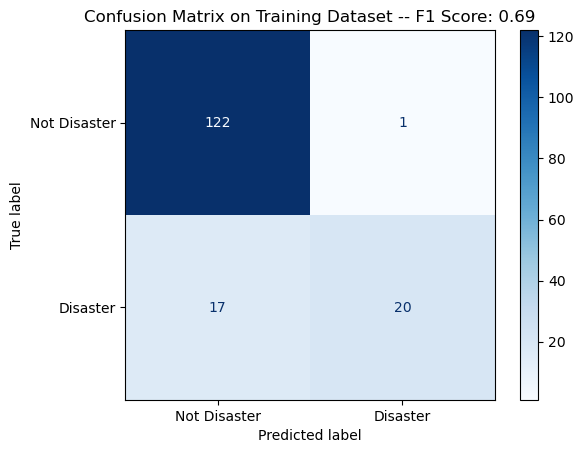

In [61]:
y_pred_train = classifier.predict(X_train)

displayConfusionMatrix(y_train, y_pred_train, "Training")

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step  


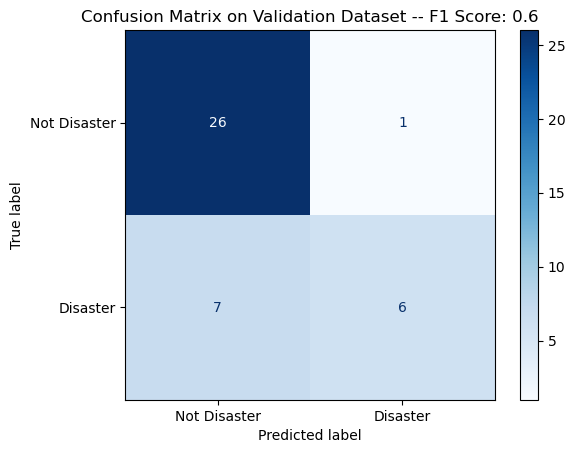

In [62]:
y_pred_val = classifier.predict(X_val)

displayConfusionMatrix(y_val, y_pred_val, "Validation")

# Generate the submission file 

For each tweets in the test set, we predict if the given tweet is about a real disaster or not. If so, predict a 1. If not, predict a 0.

The `submission.csv` file uses the following format:
`id,target`

In [63]:
#label xx 두개이므로 하나만 맞아도 제출
sample_submission = pd.read_csv("/kaggle/input/new-dataset/sample_submission.csv")
sample_submission.head()

,id,label
0,TEST_0000,55
1,TEST_0001,55
2,TEST_0002,55
3,TEST_0003,55
4,TEST_0004,55


In [66]:
result=classifier.predict(X_test)

138/138 ━━━━━━━━━━━━━━━━━━━━ 10s 66ms/step


In [67]:
result
#첫번째 데이터는 0이고 두번째데이터는 1이다

array([[ 1.6007237 , -1.8732395 ],
       [ 0.18777043, -0.3155369 ],
       [-0.19781098,  0.13896218],
       ...,
       [ 1.6556339 , -2.049811  ],
       [ 1.663175  , -1.9881898 ],
       [ 0.8026699 , -1.0036722 ]], dtype=float32)

In [69]:
result.shape

(4400, 2)

In [72]:
X_test[1]

'배송은 정말 빠르고요~ 집에서 속옷은 불편해서 안 입으려고 했는데, 약간 부끄럽기도 하고 해서 구매했어요~ 오, 사이즈도 딱 맞아요ㅎㅎ 일반적으로 사은품은 한 번에 하나씩만 주시는데 여기선 두 개를?ㅋ 정말 넉넉하시네요~ 사용해보고 재구매 결정하도록 할게요ㅎ 좋았으면 좋겠어요^^'

In [74]:
#result.argmax 확률이 높은것을 가져오기 (0과 1중)
result.argmax(1)[:10]

array([0, 0, 1, 1, 1, 0, 0, 0, 0, 0])

In [80]:
#0은 로봇 1은 사람 (사람 을 예측해야되서 1인게 높은것을 제출해야한다)
result[20:24]

array([[ 1.6867434, -2.0090811],
       [ 1.6279117, -2.0034707],
       [ 0.8395692, -1.0897281],
       [ 1.6593385, -1.9664366]], dtype=float32)

In [83]:
final_result=result[:,1].reshape(1100,4)

In [84]:
final_result

array([[-1.8732395 , -0.3155369 ,  0.13896218,  0.13818616],
       [ 0.1916925 , -1.963202  , -1.9856653 , -1.9853152 ],
       [-2.013275  , -1.5323949 , -1.9769962 , -1.8725815 ],
       ...,
       [-2.0229924 , -2.0256913 , -2.0086398 , -2.034074  ],
       [-1.9376805 , -1.9796576 , -1.9795244 , -0.52787894],
       [-1.9751396 , -2.049811  , -1.9881898 , -1.0036722 ]],
      dtype=float32)

In [93]:
#맨욋쪽은 확률낮고 오른쪽으로 갈수록 확률이 높아짐 
final_result.argsort(1)

b=[]
for i in range(1100):
    data=final_result.argsort(1)[i]
    a=str(data[3]+1) + str(data[2]+1)
    b.append(a)
    
b

['34',
 '12',
 '24',
 '24',
 '32',
 '34',
 '41',
 '12',
 '14',
 '43',
 '31',
 '21',
 '24',
 '43',
 '32',
 '13',
 '41',
 '41',
 '34',
 '34',
 '12',
 '43',
 '41',
 '14',
 '32',
 '43',
 '34',
 '24',
 '12',
 '43',
 '23',
 '24',
 '12',
 '34',
 '32',
 '31',
 '13',
 '23',
 '24',
 '21',
 '24',
 '41',
 '24',
 '13',
 '13',
 '14',
 '14',
 '41',
 '13',
 '24',
 '31',
 '32',
 '42',
 '31',
 '32',
 '14',
 '31',
 '13',
 '32',
 '21',
 '41',
 '14',
 '32',
 '23',
 '24',
 '43',
 '43',
 '14',
 '41',
 '21',
 '34',
 '21',
 '34',
 '21',
 '34',
 '42',
 '21',
 '13',
 '23',
 '21',
 '42',
 '23',
 '31',
 '32',
 '12',
 '13',
 '14',
 '14',
 '31',
 '13',
 '13',
 '14',
 '23',
 '34',
 '21',
 '14',
 '21',
 '43',
 '34',
 '34',
 '21',
 '12',
 '14',
 '12',
 '31',
 '31',
 '21',
 '13',
 '42',
 '31',
 '43',
 '21',
 '24',
 '13',
 '42',
 '43',
 '23',
 '42',
 '34',
 '31',
 '23',
 '14',
 '24',
 '32',
 '12',
 '32',
 '12',
 '42',
 '14',
 '34',
 '32',
 '31',
 '41',
 '14',
 '14',
 '23',
 '42',
 '12',
 '24',
 '21',
 '42',
 '13',
 '21',

In [94]:
sample_submission['label']=b
sample_submission

,id,label
0,TEST_0000,34
1,TEST_0001,12
2,TEST_0002,24
3,TEST_0003,24
4,TEST_0004,32
...,...,...
1095,TEST_1095,13
1096,TEST_1096,23
1097,TEST_1097,31
1098,TEST_1098,41


In [64]:
sample_submission["target"] = np.argmax(classifier.predict(X_test), axis=1)

138/138 ━━━━━━━━━━━━━━━━━━━━ 13s 92ms/step


ValueError: Length of values (4400) does not match length of index (1100)

In [ ]:
sample_submission.describe()

In [95]:
sample_submission.to_csv("submission.csv", index=False)